In [1]:
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
from langdetect import detect, detect_langs

import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv("../tos_data/tos_data.csv", error_bad_lines=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    324 non-null    int64 
 1   Link      324 non-null    object
 2   Original  322 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.7+ KB


In [2]:
def remove_multiple_space(sentence):
    clear_sentence = ' '.join(sentence.split())
    #clear_sentence = clear_sentence.lower()
    return clear_sentence

df_raw = df[df['Length'] > 300] # Deleting a HTML's text that was not properly collected.
df_raw['Original'] = df_raw['Original'].astype(str)
df_raw = df_raw.drop_duplicates(['Original'])
df_raw['Original'] = df_raw['Original'].apply(remove_multiple_space)
df_raw.describe(include=object)

<ipython-input-2-1bb8b5900bb7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Original'] = df_raw['Original'].astype(str)


,Link,Original
count,307,307
unique,307,307
top,https://www.npr.org/2020/03/04/812264543/episo...,Terms Of Use · Forrester Skip to content Blogs...
freq,1,1


In [3]:
df_raw = df_raw.drop(columns=['Length'])

def split_sentence(s):
    t_list = re.split('[;.]', s)

    return t_list

def filter_roman_number(s):
    result = []
    for t in s:
        t_result = re.split(r'\(.\) | \(..\) | \(...\) | \(....\)', t)
        result = result + t_result
        
    result = list(filter(None, result))  
    return result

def make_new_row(plist, df_raw_parsed):
    for s in plist:
        new_row = {
            'Link': row['Link'],
            'Original': s,
        }
        df_raw_parsed = df_raw_parsed.append(new_row, ignore_index=True)
    return df_raw_parsed

df_raw_parsed = pd.DataFrame(columns=['Link', 'Original'])
for i, row in df_raw.iterrows():
    t_list = split_sentence(row['Original'])
    f_list = filter_roman_number(t_list)

    if not f_list:
        df_raw_parsed = make_new_row(t_list, df_raw_parsed)
    else:
        df_raw_parsed = make_new_row(f_list, df_raw_parsed)



In [4]:
df_raw_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102136 entries, 0 to 102135
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Link      102136 non-null  object
 1   Original  102136 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [5]:
df_raw_parsed['Length'] = df_raw_parsed['Original'].apply(lambda x: len(x)) # Create new 'Length' column.
df_raw_parsed = df_raw_parsed[['Length', 'Link', 'Original']]
df_raw_parsed = df_raw_parsed[df_raw_parsed['Length'] > 50]

In [6]:
df_raw_parsed.describe(include=object)

,Link,Original
count,67347,67347
unique,307,61306
top,http://www.three.co.uk/terms-conditions,"By submitting an entry, entrants will be deem..."
freq,6027,41


In [7]:
df_raw_parsed['Original'] = df_raw_parsed['Original'].astype(str)
df_raw_parsed = df_raw_parsed.drop_duplicates(['Original']) # Remove duplicate data. Remain unique data in column.
df_raw_parsed.describe(include=object)

,Link,Original
count,61306,61306
unique,307,61306
top,http://www.three.co.uk/terms-conditions,"Afterpay reserves the right, at its own expen..."
freq,3983,1


In [8]:
df_raw_parsed.to_csv(Path(os.getcwd() + "/" + "test1_tos_data.csv"), index=False) 

In [9]:
def detect_english_sentence(sentence):
    res = detect_langs(sentence)
    for item in res:
        if item.lang == "en" and item.prob > 0.99:
            return True
        else:
            return False

def make_space(sentence):
    result =[]
    # Insert a space such as "HelloWorld" -> "Hello World"
    result = re.sub(r"([a-z])([A-Z])([a-z])", r"\1 \2\3", sentence)
    return result

for i, row in df_raw_parsed.iterrows():
    # s = re.sub("[^A-Za-z'\s,]+", "", row['Original'].strip())
    if detect_english_sentence(row['Original']) == True:
        result = make_space(row['Original'])
    else:
        result = ""
    df_raw_parsed.loc[i, 'Original'] = result

In [12]:
df_raw_parsed.to_csv(Path(os.getcwd() + "/" + "test_tos_data.csv"), index=False) 

In [13]:
# Compare data that calculated length of whole sentence each pandas.
# Through this, you can see how much data is lost after parsing.

# df_raw = df_raw[df_raw['Original'] != '']
# df_raw['Original'] = df_raw['Original'].astype(str)
# df_raw = df_raw.drop_duplicates(['Original'])

# sum_df_raw = 0
# sum_df_raw_parsed = 0

# for i, row in df_raw.iterrows():
#     sum_df_raw = sum_df_raw + len(row['Original'])

# for i, row in df_raw_parsed.iterrows():
#     sum_df_raw_parsed = sum_df_raw_parsed + len(row['Original'])

# print('Before text parsing {0}, After text parsing {1}'.format(sum_df_raw, sum_df_raw_parsed))

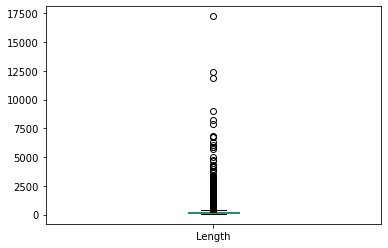

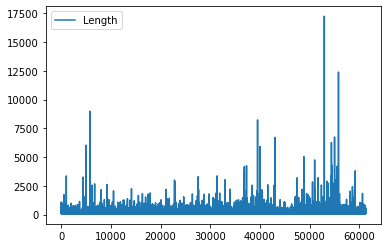

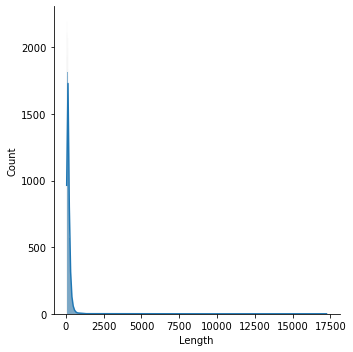

In [14]:
df_raw_parsed = df_raw_parsed.reset_index(drop=True)
df_raw_parsed.plot(kind='box', figsize=(6,4))
df_raw_parsed.plot()
sns.displot(df_raw_parsed['Length'], kde=True)
# Reference: https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html

In [15]:
df_raw_parsed.describe(exclude=object)

,Length
count,61306.000000
mean,178.346964
std,206.824384
min,51.000000
25%,96.000000
50%,141.000000
75%,210.000000
max,17246.000000


In [16]:
# df_raw_parsed_test = df_raw_parsed.sort_values(by='Length') # data sorted by descending order.
# df_raw_parsed_test = df_raw_parsed_test.reset_index(drop=True)
# df_raw_parsed_test

In [17]:
# np.percentile(df_raw_parsed_test['Length'], [5, 95], interpolation='nearest') # For readability, extract sentences based on 5%ile, 95%ile.

In [18]:
# df_raw_parsed_test = df_raw_parsed_test[(df_raw_parsed_test['Length'] >= 60) & (df_raw_parsed_test['Length'] <= 371)]
# df_raw_parsed_test

In [19]:
# import sklearn

# df_shuffled = df_shuffled.drop(columns=['Length'])
# df_shuffled = sklearn.utils.shuffle(df_shuffled)
# df_shuffled.to_csv(Path(os.getcwd() + "/" + "shuffled_tos_data.csv"), index=False)